In [38]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In this project, I aim to evaluate the truthfulness of the claim known as Lawler's Law — that 90% of the time, the team that scores 100 points first in an NBA game goes on to win. To do this, I will obtain play-by-play (PBP) data for the 2000–01 to 2018–19 NBA seasons from https://sports-statistics.com/sports-data/nba-basketball-datasets-csv-files/. This data captures each individual play in a game, such as scoring attempts, rebounds, fouls, and more.

After cleaning the dataset by removing unnecessary metadata, I will create two key dataframes at the game level: one to identify which team (home or visitor) scored 100 points first, and another to determine which team ultimately won the game. By merging these, I will be able to assess whether Lawler's Law held true for each game — that is, whether the team that reached 100 points first also won. I will then calculate the overall accuracy of Lawler’s Law across all games and examine how it varies season by season. I also shall create a line plot to visualize the accuracy of Lawler's Law season by season.

In [39]:
#function to clean csv files
def clean_pbp_data(file_path):
    #reading csv files from folder
    df = pd.read_csv(file_path)
    #dropping metadata/unnecessary columns
    cols_to_drop = ['PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE',
                    'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION',
                    'PLAYER1_TEAM_CITY', 'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME',
                    'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION',
                    'PLAYER2_TEAM_CITY', 'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME',
                    'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION',
                    'PLAYER3_TEAM_CITY', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME',
                    'NEUTRALDESCRIPTION', 'Unnamed: 0', 'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE']
    #dropping unnecessary metadata/columns
    df = df.drop(columns=cols_to_drop, errors='ignore')
    #dropping rows where action is not a scoring play
    df = df[df['SCORE'].notna()]
    #making columns for visitor score and home score (as integers)
    df[['VISITOR_SCORE', 'HOME_SCORE']] = df['SCORE'].str.split(' - ', expand=True).astype(int)
    #convert PCTIMESTRING to seconds remaining in the period
    df['SECONDS_REMAINING'] = df['PCTIMESTRING'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
    #sorting events chronologically
    df = df.sort_values(by=['GAME_ID', 'PERIOD', 'SECONDS_REMAINING'], ascending=[True, True, False])
    #drop helper column
    df = df.drop(columns=['SECONDS_REMAINING'])
    return df

#function to find whether home team or visiting team scored 100 points first
def get_first_to_100(group):
    first_100 = group[(group['HOME_SCORE'] >= 100) | (group['VISITOR_SCORE'] >= 100)].head(1)
    if first_100.empty:
        return pd.Series({'First To 100': None})
    elif first_100['HOME_SCORE'].values[0] >= 100 and first_100['VISITOR_SCORE'].values[0] < 100:
        return pd.Series({'First To 100': 'Home'})
    else:
        return pd.Series({'First To 100': 'Visitor'})

#function to get who won the game
def get_winner(group):
    last = group.tail(1)
    if last['HOME_SCORE'].values[0] > last['VISITOR_SCORE'].values[0]:
        return pd.Series({'Winner': 'Home'})
    else:
        return pd.Series({'Winner': 'Visitor'})

#process play-by-play data for a single NBA season
def process_season(file_path, season_label):
    #create dataframe with cleaned data for single NBA season
    df = clean_pbp_data(file_path)
    
    #apply get_first_to_100 and get_winner functions to cleaned dataframe
    first_100_df = df.groupby('GAME_ID', group_keys = False).apply(get_first_to_100, include_groups = False).reset_index()
    winners_df = df.groupby('GAME_ID', group_keys = False).apply(get_winner, include_groups = False).reset_index()
    
    #merge both dataframes
    merged = pd.merge(first_100_df, winners_df, on = 'GAME_ID')
    #drop games where neither team scored 100 points
    merged = merged[merged['First To 100'].notnull()]
    #create column showing if Lawler's Law is upheld
    merged['Lawler\'s Law Correct'] = merged['First To 100'] == merged['Winner']
    #create column showing which season the data belongs to
    merged['Season'] = season_label
    return merged

In [40]:
all_results = []

#import folder containing CSVs
data_dir = 'NBA PBP Data 2000-2018/'
#process every NBA season in folder and combine results into one dataFrame
for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        season_label = file.replace('_pbp.csv', '')
        file_path = os.path.join(data_dir, file)
        print(f"Processing: {season_label}")
        result_df = process_season(file_path, season_label)
        all_results.append(result_df)

#combine all seasons
final_all_seasons_df = pd.concat(all_results, ignore_index=True)


Processing: 2002-03
Processing: 2008-09
Processing: 2000-01
Processing: 2003-04
Processing: 2015-16
Processing: 2007-08
Processing: 2006-07
Processing: 2011-12
Processing: 2004-05
Processing: 2013-14
Processing: 2005-06
Processing: 2018-19
Processing: 2010-11
Processing: 2009-10
Processing: 2012-13
Processing: 2014-15
Processing: 2001-02
Processing: 2016-17
Processing: 2017-18


In [41]:
#overall Lawler's Law accuracy from 2000-01 to 2018-19
overall_accuracy = final_all_seasons_df['Lawler\'s Law Correct'].mean()
print(f"\nOverall Lawler's Law Accuracy: {overall_accuracy:.2%}")

#Lawler's Law accuracy by season
accuracy_by_season = (
    final_all_seasons_df.groupby('Season')['Lawler\'s Law Correct']
    .mean()
    .sort_index()
)
print("\nAccuracy by Season:")
print(accuracy_by_season.apply(lambda x: f"{x:.2%}"))


Overall Lawler's Law Accuracy: 92.69%

Accuracy by Season:
Season
2000-01    95.04%
2001-02    95.73%
2002-03    92.28%
2003-04    94.66%
2004-05    92.86%
2005-06    93.47%
2006-07    92.75%
2007-08    94.23%
2008-09    92.70%
2009-10    93.40%
2010-11    93.75%
2011-12    94.13%
2012-13    92.46%
2013-14    93.17%
2014-15    94.27%
2015-16    93.44%
2016-17    90.06%
2017-18    90.27%
2018-19    87.91%
Name: Lawler's Law Correct, dtype: object


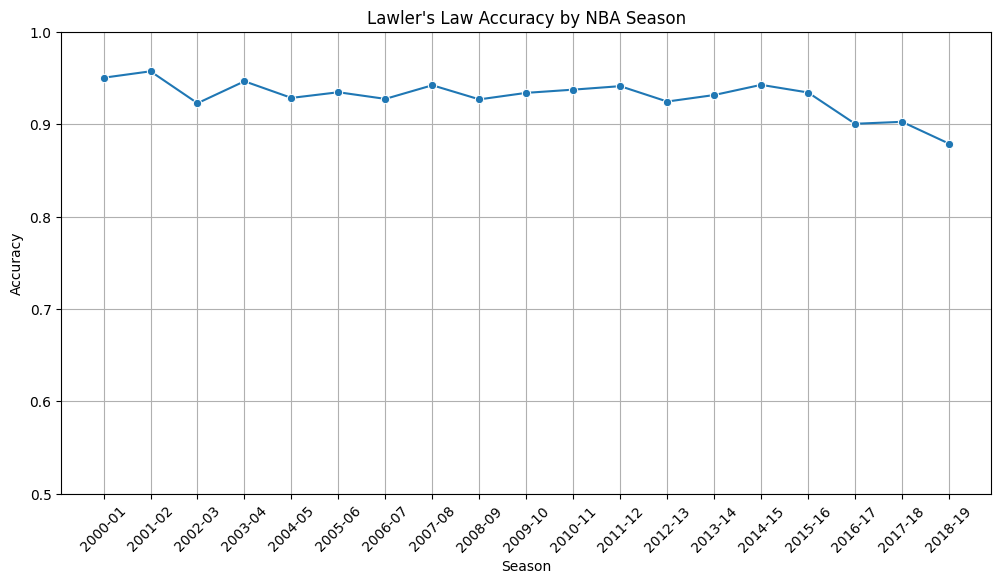

In [42]:
#group by season and calculate accuracy
seasonal_accuracy = final_all_seasons_df.groupby('Season')["Lawler's Law Correct"].mean().reset_index()

#sort seasons chronologically
seasonal_accuracy = seasonal_accuracy.sort_values('Season')

#line graph showing accuracy over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_accuracy, x='Season', y="Lawler's Law Correct", marker='o')
plt.xticks(rotation=45)
plt.title("Lawler's Law Accuracy by NBA Season")
plt.ylabel("Accuracy")
plt.xlabel("Season")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.show()

In this next part, I will remove games that are considered 'blowouts', where the point differential at 100 points is 20 or greater. This is because teams have a very minimal chance of coming back to win at that point. I will do the same thing as above, finding the overall accuracy and seasonal accuracy of Lawler's Law. I shall again create a line plot showing the accuracy of Lawler's Law season by season, and comparing it with the line plot generated previously.

In [43]:
#function to get point differential at 100 points
def get_point_diff_at_100(group):
    first_100 = group[(group['HOME_SCORE'] >= 100) | (group['VISITOR_SCORE'] >= 100)].head(1)
    #if neither team reached 100 points
    if first_100.empty:
        return pd.Series({'Point Diff @ 100': None})
    home_score = first_100['HOME_SCORE'].values[0]
    visitor_score = first_100['VISITOR_SCORE'].values[0]
    #calculate differential
    return pd.Series({'Point Diff @ 100': abs(home_score - visitor_score)})

#compute point differential at 100-point mark per game
point_diff_dfs = []

#find point differential for every game in every NBA season in folder
for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        season_label = file.replace('_pbp.csv', '')
        file_path = os.path.join(data_dir, file)
        print(f"Processing: {season_label}")
        df = clean_pbp_data(file_path)
        diffs = df.groupby('GAME_ID', group_keys = False).apply(get_point_diff_at_100, include_groups = False).reset_index()
        diffs['Season'] = season_label
        point_diff_dfs.append(diffs)

#combine all differential data
point_diff_all = pd.concat(point_diff_dfs, ignore_index = True)

#merge with final results
final_with_diffs = pd.merge(final_all_seasons_df, point_diff_all, on=['GAME_ID', 'Season'])

#filter out blowouts (point diff at 100 >= 20)
non_blowouts_df = final_with_diffs[final_with_diffs['Point Diff @ 100'] < 20]

Processing: 2002-03
Processing: 2008-09
Processing: 2000-01
Processing: 2003-04
Processing: 2015-16
Processing: 2007-08
Processing: 2006-07
Processing: 2011-12
Processing: 2004-05
Processing: 2013-14
Processing: 2005-06
Processing: 2018-19
Processing: 2010-11
Processing: 2009-10
Processing: 2012-13
Processing: 2014-15
Processing: 2001-02
Processing: 2016-17
Processing: 2017-18


In [44]:
#overall Lawler's Law accuracy from 2000-01 to 2018-19 (excluding blowouts)
non_blowout_accuracy = non_blowouts_df["Lawler's Law Correct"].mean()
print(f"\nLawler's Law Accuracy (Excluding Blowouts): {non_blowout_accuracy:.2%}")

#Lawler's Law accuracy by season (excluding blowouts)
non_blowout_accuracy_by_season = (
    non_blowouts_df.groupby('Season')['Lawler\'s Law Correct']
    .mean()
    .sort_index()
)
print("\nLawler's Law Accuracy by Season (Excluding Blowouts):")
for season, accuracy in non_blowout_accuracy_by_season.items():
    print(f"{season}: {accuracy:.2%}")


Lawler's Law Accuracy (Excluding Blowouts): 90.70%

Lawler's Law Accuracy by Season (Excluding Blowouts):
2000-01: 93.81%
2001-02: 94.43%
2002-03: 89.79%
2003-04: 93.25%
2004-05: 91.11%
2005-06: 91.75%
2006-07: 90.92%
2007-08: 92.46%
2008-09: 90.84%
2009-10: 91.44%
2010-11: 92.26%
2011-12: 91.89%
2012-13: 90.16%
2013-14: 91.37%
2014-15: 92.63%
2015-16: 91.67%
2016-17: 87.54%
2017-18: 87.78%
2018-19: 85.07%


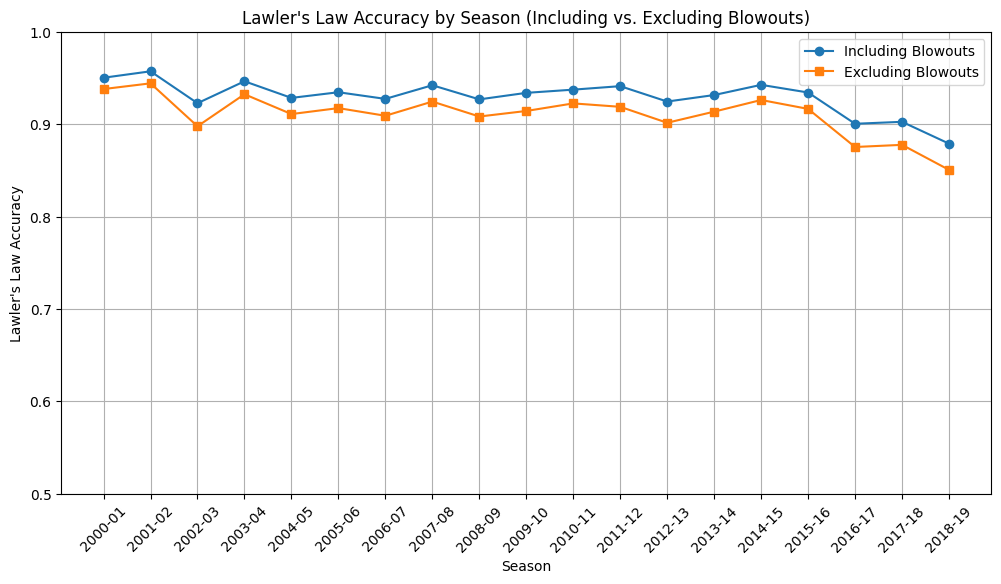

In [45]:
plt.figure(figsize=(12, 6))
#plot including blowouts
plt.plot(accuracy_by_season.index, accuracy_by_season.values, marker='o', label='Including Blowouts')
#plot excluding blowouts
plt.plot(non_blowout_accuracy_by_season.index, non_blowout_accuracy_by_season.values, marker='s', label='Excluding Blowouts')
plt.xlabel('Season')
plt.ylabel('Lawler\'s Law Accuracy')
plt.title('Lawler\'s Law Accuracy by Season (Including vs. Excluding Blowouts)')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.show()

Below, I am only evaluating Lawler's Law's accuracy on close games, commonly referred to as games with a margin of 10 points or less. I will do the same processes as above, and also compare the line plot created with the two previous ones.

In [46]:
#filter out non-close games (point diff at 100 > 10)
close_games_df = final_with_diffs[final_with_diffs['Point Diff @ 100'] < 11]

#overall Lawler's Law accuracy from 2000-01 to 2018-19 (only close games)
close_games_accuracy = close_games_df["Lawler's Law Correct"].mean()
print(f"\nLawler's Law Accuracy (Close Games Only): {close_games_accuracy:.2%}")

#Lawler's Law accuracy by season (excluding blowouts)
close_games_accuracy_by_season = (
    close_games_df.groupby('Season')['Lawler\'s Law Correct']
    .mean()
    .sort_index()
)
print("\nLawler's Law Accuracy by Season (Close Games Only):")
for season, accuracy in close_games_accuracy_by_season.items():
    print(f"{season}: {accuracy:.2%}")


Lawler's Law Accuracy (Close Games Only): 85.53%

Lawler's Law Accuracy by Season (Close Games Only):
2000-01: 89.93%
2001-02: 90.94%
2002-03: 84.72%
2003-04: 89.16%
2004-05: 86.23%
2005-06: 87.22%
2006-07: 85.93%
2007-08: 87.59%
2008-09: 86.54%
2009-10: 85.79%
2010-11: 88.31%
2011-12: 86.19%
2012-13: 83.84%
2013-14: 86.40%
2014-15: 87.59%
2015-16: 87.76%
2016-17: 81.27%
2017-18: 81.85%
2018-19: 76.98%


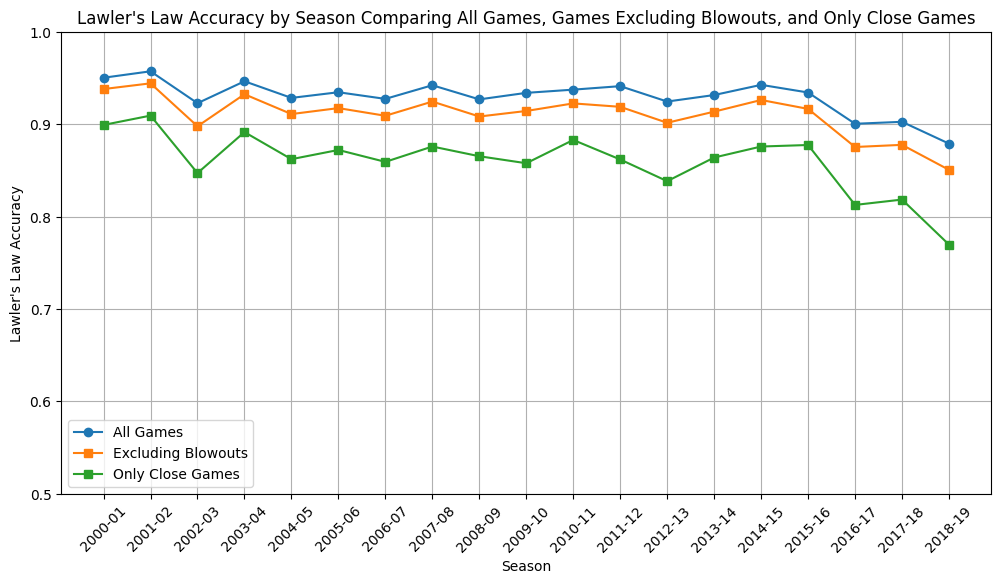

In [47]:
plt.figure(figsize=(12, 6))
#plot including blowouts
plt.plot(accuracy_by_season.index, accuracy_by_season.values, marker='o', label='All Games')
#plot excluding blowouts
plt.plot(non_blowout_accuracy_by_season.index, non_blowout_accuracy_by_season.values, marker='s', label='Excluding Blowouts')
#plot only close games
plt.plot(close_games_accuracy_by_season.index, close_games_accuracy_by_season.values, marker='s', label='Only Close Games')
plt.xlabel('Season')
plt.ylabel('Lawler\'s Law Accuracy')
plt.title('Lawler\'s Law Accuracy by Season Comparing All Games, Games Excluding Blowouts, and Only Close Games')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.show()

In [48]:
#defining features to do logistic regression
final_with_diffs['Reached_100_Winner'] = (final_with_diffs['First To 100'] == final_with_diffs['Winner']).astype(int)
final_with_diffs['Home_Reached_100'] = (final_with_diffs['First To 100'] == 'Home').astype(int)
final_with_diffs['Is_Home_Winner'] = (final_with_diffs['Winner'] == 'Home').astype(int)
final_with_diffs['Signed Point Diff @ 100'] = final_with_diffs.apply(
    lambda row: row['Point Diff @ 100'] if row['First To 100'] == 'Home' 
    else -row['Point Diff @ 100'], axis=1)
final_with_diffs['Is_Close_Game'] = (final_with_diffs['Point Diff @ 100'] <= 10).astype(int)
final_with_diffs['Is_Blowout'] = (final_with_diffs['Point Diff @ 100'] >= 20).astype(int)

feature_cols = [
    'Home_Reached_100', 
    'Point Diff @ 100',
    'Signed Point Diff @ 100',
    'Is_Close_Game',
    'Is_Blowout'
]
X = final_with_diffs[feature_cols]
y = final_with_diffs['Reached_100_Winner']

#create training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

#predict on test set
y_pred = model.predict(X_test)

#evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#print coefficients
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + X.columns.tolist(),
    'Coefficient': [model.intercept_[0]] + model.coef_[0].tolist()
})
print("\nLogistic Regression Coefficients:")
print(coefficients)

Confusion Matrix:
[[   0  230]
 [   0 2883]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.93      1.00      0.96      2883

    accuracy                           0.93      3113
   macro avg       0.46      0.50      0.48      3113
weighted avg       0.86      0.93      0.89      3113


Logistic Regression Coefficients:
                   Feature  Coefficient
0                Intercept    -0.256880
1         Home_Reached_100     0.318414
2         Point Diff @ 100     0.318452
3  Signed Point Diff @ 100     0.003138
4            Is_Close_Game     0.348700
5               Is_Blowout    -0.157694


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_